## How we built Observ's Power Burn Forecast ##

Let's assume you care about gas fundamentals. Then you have spent a lot of the past three years pondering about the forecast of power burn. How much demand is there going to be at this price level? How do I model the switching? 

Some people model with a rough regression built at national level. Some use power generation data from alternative fuel as a directional indicator. Some may even try borrowing plant-level stack model from power traders.  Don’t worry. I have tried them all, too —  and it was tedious, exhausting, and not all that predictive.

But what if we take the best out of all other methods and combine them together? This analysis is about a new approach in power burn modeling. The kind of model that brings you closer to understanding the gas market.

### Step 1 : Evaluate the methodologies ###

The more I play with EIA data, the more I love America. To have this much data public at such a granularity is amazing. This is a data scientist's wild dream. 

But it's not perfect. The API is buggy and finding the right data series for the analysis is tricky. 

To model power burn, we combed through the electricity data but did not find any good leads. That's when we  started to debate on each method:

*Regression at national level* - RISKY. Regional dynamic has evolved so much in the past five years. Even splitting by EIA storage region is too broad. Modeling at state level is the way to go.

*Using power generation data from alternative fuel as a directional indicator* - SPOTTY. Generation from renewables, hydro, and coal are helpful in explaining some changes. But it's same as playing Monday morning quarterback. Totally makes sense from hindsight but I wouldn't trade on it.

*Using Power trader's plant-level stack model* - COSTLY. Licensing fees on the stack model runs in the six-figures. That doesn't even include internal headcount to run the model. Power stack model has way too many variables. Probably useful in project finance. But trading gas... no.

**Then we had an epiphany -- Let's combine all the models!**: To get the merit of power stack model, we'll look at plant-level data. To get regional signals, we will model the burn by state.  To get signals from other fuels, we will make adjustments.

### Step 2 : Sort through power plants. Tried machine learning. But at this scale, humans are plenty enough for version 1 of the model ###

So, at plant level, can we spot the changes in generation as prices fluctuate?

We plot the generation of each gas-fired power plants against temperature, **by year**. We began to notice that while some gas-fired plants do increase generation in 2012 when the price was low, not all of them do. 

**For those that do increase the generation when gas price is low (2012 vs 2011), we would mark them as elastic. For those that keep generation at the same level, we would label them inelastic.**

Let's look at some examples:

In [15]:
import plant_analysis as plant

This plant (ID 3452) did not increase its generation in 2012 ansd 2013 vs 2011. We label this one as **inelastic.**

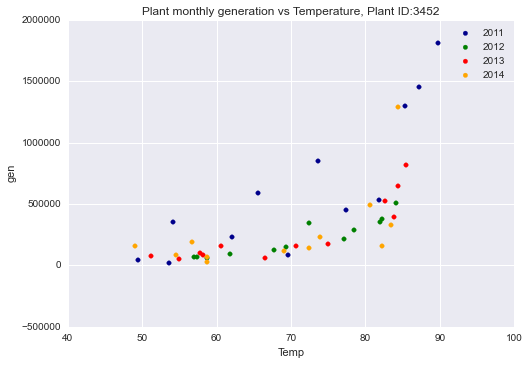

In [16]:
plant.pull_inelastic_sample() 

This is a plant that DID increase its generation in 2012 and 2013 vs 2011. We label this one as **elastic**.

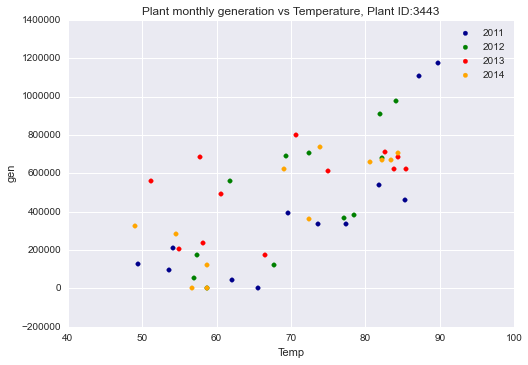

In [14]:
plant.pull_elastic_sample()

We classify all the gas-fired power plants in the US as such.

### Step 3 : Combine them with some python magic ###

Now we have all the gas-fired plants grouped into either elastic or inelastic. It's time to bring in other variables: 

**Temperature**: Daily temperature for each state.

**Cash prices**: Physical settlements of each states. Using hubs that are liquid enough for power plant operators to transact hedges.

**Coal prices**: Using coal forward curve. We can spend three days arguing about how to treat coal prices and still left with no consensus. But one thing is for sure - **Price-parity chart is useless.**

**Hydro** - EIA hydro generation data . Pull in BPA data, etc to refine forecasts.

**Nuclear outages** - NERC data.

Then it's python magic time! We rely on lots of [Sci-kit learn](http://scikit-learn.org/stable/) nearest neighbor regression functions. The goal is to find the relationship among all these variable with the power burn of the elastic group and the inelastic group, for each state. 

### Part 4 : Add all the other pieces. Alternative fuel definitely matters. We account for them with arithmetic from stack model. ###

After all the black magic of machine learning, we then come back to regular arithmetic and start making some adjustments:

1. New natural gas plant build
2. Gas plant retirement
3. Coal plant retirement
4. Growth in renewables
5. Wind generation
6. Solar generation 


With about 15 variables and calculated at state level, the model may seem busy. But, phew, this is like a poem compared to power stack model.

### Part 5: The fun part begins... ###

Once the forecasts are out, it's how we use the forecasts that creates our edge. Here are some ideas:
1. Compare how the forecast has changed. Getting the trend right is so much useful than getting the precision. No one gets paid for nailing the power burn monthly to one decimal place. You get paid when you get the market surprises and price action right.
2. Use the power burn number to forecast weekly storage number. You can either forecast the storage number with storage samples. Or, you can forecast it with net S&D.  Opportunities rise when forecasts of the two method diverge.
3. Scenario analysis is where this model shines! When we feed various scenarios, we see that the results are not distributed normally. The distribution is asymmetrical. It's always worth the ad hoc analysis when you spot asymmetry in the modeling results.
4. We can also try move the price curve around and observe how demand responds.


These are just a few big ideas to leverage the power burn modeling. There are other directions like drilling down to the impact of specific variable, etc. But that's for another time.